# MNIST

### Data Acquisition

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

### Viewing a digit

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [7]:
plt.style.use('dark_background')

In [8]:
some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)

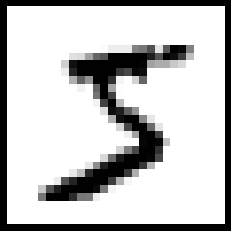

In [9]:
plt.imshow(some_digit_image, cmap= mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [10]:
# check the label 
y.iloc[0]

'5'

In [11]:
# the labels are originally strings. Need to cast y to integers
y = y.astype(np.uint8)

### Creating Train and Test Sets

In [12]:
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

#### Training a Binary Classifier (5 or not 5)

In [13]:
# create the target vectors
y_train_5 = (y_train == 5) # true for all 5s. False for all other digits
y_test_5 = (y_test == 5)

In [14]:
from sklearn.linear_model import SGDClassifier

In [15]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [16]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Implement Cross-Validation

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone


In [18]:
skfolds = StratifiedKFold(n_splits=3)

In [19]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))    

0.95035
0.96035
0.9604


In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Accuracy is not generally preferred performance measure for classifiers specially when dealing with skewed datasets. In this case, each digit has around 10% of the population and using a binary classifier, it will always have at least 90% of accuracy

### Confusion Matrix

In [22]:
from sklearn.model_selection import cross_val_predict

In [23]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

### Precision and Recall

In [26]:
from sklearn.metrics import precision_score, recall_score

In [27]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [28]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [29]:
# f1 score
from sklearn.metrics import f1_score

In [30]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### Precision/Recall trade-off

In [31]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [32]:
threshold = 0
y_some_digit_pred = (y_scores > threshold) # returns True as predict() method
y_some_digit_pred

array([ True])

In [33]:
# increasing the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold) # returns false
y_some_digit_pred

array([False])

In [34]:
# get the decision scores for X_train to decide on threshold
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [35]:
# compute precision and recall for all possible thresholds using the precision_recall_curve()
from sklearn.metrics import precision_recall_curve

In [36]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [37]:
precisions

array([0.09040123, 0.09038606, 0.09038757, ..., 1.        , 1.        ,
       1.        ])

In [38]:
recalls

array([1.00000000e+00, 9.99815532e-01, 9.99815532e-01, ...,
       3.68935621e-04, 1.84467810e-04, 0.00000000e+00])

In [39]:
thresholds

array([-106527.45300471, -105763.22240074, -105406.2965229 , ...,
         38871.26391927,   42216.05562787,   49441.43765905])

In [40]:
# print precision and recall  as functions of the threshold
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(12,9))
    plt.plot(thresholds, precisions[:-1], '--', label='Precision', color='orange')
    plt.plot(thresholds, recalls[:-1], '-', label='Recall', color='magenta')
    plt.legend()
    plt.grid(b=True)
    plt.xlabel('THRESHOLD')

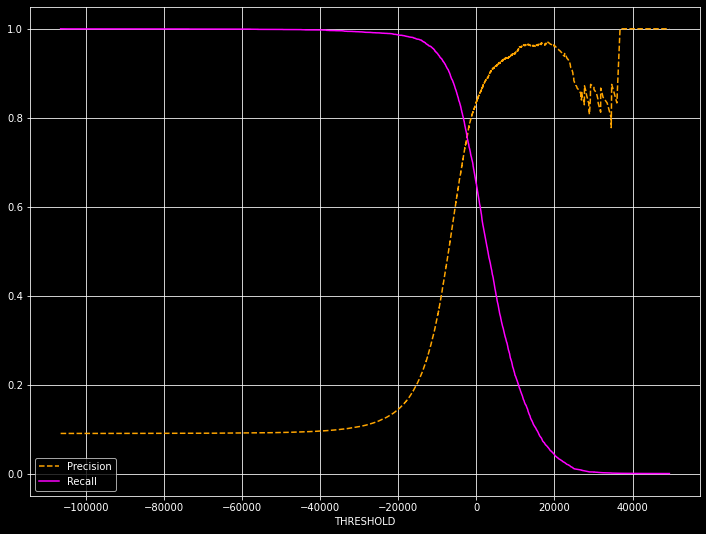

In [41]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


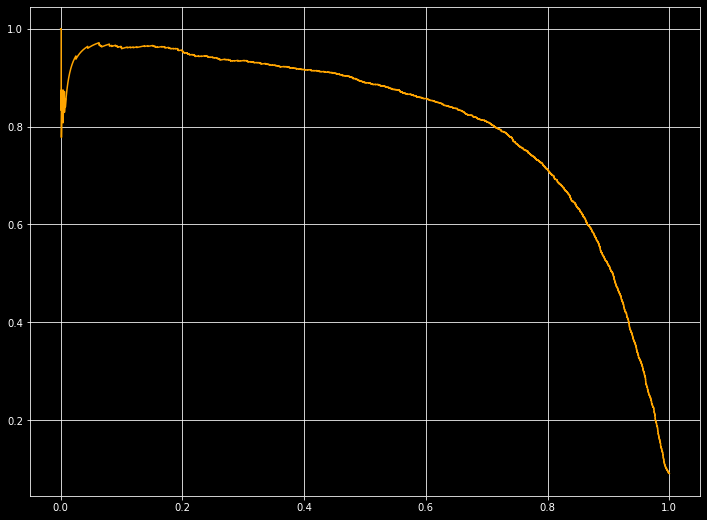

In [42]:
# plot precision against recall
plt.figure(figsize=(12,9))
plt.plot(recalls, precisions, color='orange')
plt.grid(b=True)


In [43]:
# decide to have 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [44]:
# make predictions on the training set using the threshold precision
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [45]:
p_score = precision_score(y_train_5, y_train_pred_90)
p_score

0.9000345901072293

In [46]:
r_score = recall_score(y_train_5, y_train_pred_90)
r_score

0.4799852425751706

### ROC Curve

In [47]:
from sklearn.metrics import roc_curve

In [59]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [49]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(12,9))
    plt.plot(fpr, tpr, linewidth=2, label=label, color='orange')
    plt.plot([0, 1], [0,1], 'k--')
    plt.xlabel('FPR - False Positive Rate')
    plt.ylabel('TPR - True Positive Rate')
    plt.grid(True)

In [51]:
from sklearn.metrics import roc_auc_score

In [52]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Using a Random Forerst Classifier

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
forest_clf = RandomForestClassifier(random_state=42)

In [55]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [56]:
y_scores_forest = y_probas_forest[:, 1] # probability of the positive class (5s)

In [60]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

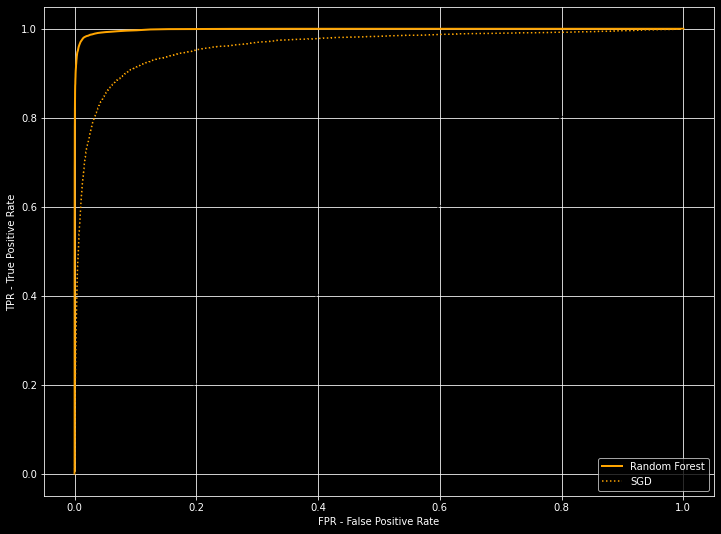

In [61]:
#plot the ROC Curve
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.plot(fpr, tpr, 'b:', label='SGD', color='orange')
plt.legend(loc='lower right')

RandomForestClassifier's ROC curve looks much better than the SGD. (closer to the top left)

In [62]:
# calculate the ROC AUC
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### Multiclass Classification

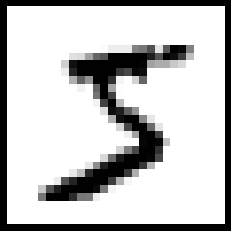

In [63]:
some_digit = X_train.iloc[0]
some_digit_image = some_digit.values.reshape(28, 28)
plt.imshow(some_digit_image, cmap= mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [64]:
sgd_clf2 = SGDClassifier(random_state=42)
sgd_clf2.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [65]:
sgd_clf2.predict([some_digit]) # wrong prediction

array([3], dtype=uint8)

In [66]:
# get scores using the decision function
some_digit_scores = sgd_clf2.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [67]:
sgd_clf2.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [68]:
from sklearn.multiclass import OneVsOneClassifier

In [69]:
# forcing one versus one
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))

In [70]:
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(random_state=42))

In [71]:
ovo_clf.predict([some_digit]) # write prediction

array([5], dtype=uint8)

In [72]:
# training a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

In [73]:
forest_clf2 = RandomForestClassifier(random_state=42)

In [74]:
forest_clf2.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [75]:
forest_clf2.predict([some_digit]) # right prediction

array([5], dtype=uint8)

In [76]:
forest_clf2.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [77]:
# evaluate sgd classifier
cross_val_score(sgd_clf2, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [78]:
cross_val_score(forest_clf2, X_train, y_train, cv=3, scoring='accuracy')

array([0.9646 , 0.96255, 0.9666 ])

In [79]:
# create confusion matrix
y_train_pred = cross_val_predict(sgd_clf2, X_train, y_train, cv=3)

In [80]:
conf_mx = confusion_matrix(y_train, y_train_pred)

In [81]:
conf_mx

array([[5635,    0,   61,   10,   16,   50,   46,    7,   66,   32],
       [   3, 6393,   95,   21,   16,   47,   15,   27,  109,   16],
       [  72,   56, 5174,   89,   69,   39,  163,   66,  212,   18],
       [  58,   32,  217, 4941,   23,  441,   32,   56,  216,  115],
       [  11,   26,   46,    6, 5298,   26,   73,   32,   87,  237],
       [  68,   23,   58,  150,   83, 4606,  174,   26,  152,   81],
       [  40,   13,   56,    6,   22,  113, 5625,    5,   36,    2],
       [  23,   24,  103,   36,  124,   40,   10, 5228,   75,  602],
       [  40,  101,  158,  122,   49,  457,   77,   35, 4666,  146],
       [  33,   18,   66,   83,  515,  127,    4,  485,  166, 4452]])

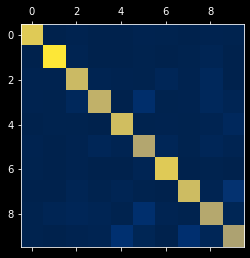

In [82]:
plt.matshow(conf_mx, cmap=plt.cm.cividis)
plt.show()

In [83]:
# plot focusing on the errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
row_sums

array([[5923],
       [6742],
       [5958],
       [6131],
       [5842],
       [5421],
       [5918],
       [6265],
       [5851],
       [5949]])

In [84]:
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

array([[9.51375992e-01, 0.00000000e+00, 1.02988350e-02, 1.68833361e-03,
        2.70133378e-03, 8.44166807e-03, 7.76633463e-03, 1.18183353e-03,
        1.11430019e-02, 5.40266757e-03],
       [4.44971818e-04, 9.48234945e-01, 1.40907743e-02, 3.11480273e-03,
        2.37318303e-03, 6.97122516e-03, 2.22485909e-03, 4.00474637e-03,
        1.61673094e-02, 2.37318303e-03],
       [1.20845921e-02, 9.39912722e-03, 8.68412219e-01, 1.49378986e-02,
        1.15810675e-02, 6.54582075e-03, 2.73581739e-02, 1.10775428e-02,
        3.55824102e-02, 3.02114804e-03],
       [9.46012070e-03, 5.21937694e-03, 3.53938999e-02, 8.05904420e-01,
        3.75142717e-03, 7.19295384e-02, 5.21937694e-03, 9.13390964e-03,
        3.52307943e-02, 1.87571359e-02],
       [1.88291681e-03, 4.45053064e-03, 7.87401575e-03, 1.02704553e-03,
        9.06881205e-01, 4.45053064e-03, 1.24957206e-02, 5.47757617e-03,
        1.48921602e-02, 4.05682985e-02],
       [1.25438111e-02, 4.24275964e-03, 1.06991330e-02, 2.76701716e-02,
   

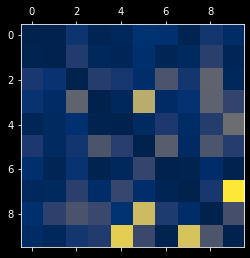

In [85]:
# fill the diagonal with zeros to keel only the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.cividis)
plt.show()

In [86]:
X_train

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [ ]:
y_train_pred == 3

In [ ]:
y_train.values == 3

In [ ]:
# Analysing classes 3 and 5
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

### Multilabel Classification

In [88]:
from sklearn.neighbors import KNeighborsClassifier

In [89]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [92]:
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [93]:
knn_clf = KNeighborsClassifier()


In [94]:
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [95]:
knn_clf.predict([some_digit]) # 5 <= 7 and is odd

array([[False,  True]])

In [96]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [97]:
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

### Multioutput Classification

In [98]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
X_train_mod

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,99.0,8.0,15.0,42.0,50.0,40.0,19.0,22.0,80.0,24.0,...,73.0,32.0,47.0,47.0,45.0,31.0,98.0,76.0,51.0,8.0
1,76.0,18.0,24.0,61.0,29.0,25.0,96.0,38.0,34.0,81.0,...,45.0,52.0,64.0,17.0,15.0,16.0,17.0,12.0,33.0,94.0
2,93.0,93.0,61.0,98.0,50.0,5.0,12.0,29.0,81.0,40.0,...,19.0,7.0,5.0,44.0,32.0,59.0,93.0,25.0,34.0,29.0
3,22.0,14.0,76.0,77.0,46.0,47.0,42.0,16.0,55.0,31.0,...,26.0,98.0,99.0,69.0,43.0,82.0,3.0,37.0,29.0,7.0
4,11.0,67.0,77.0,14.0,73.0,83.0,42.0,58.0,13.0,34.0,...,20.0,32.0,92.0,24.0,37.0,54.0,93.0,19.0,7.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,98.0,46.0,13.0,30.0,59.0,20.0,12.0,8.0,27.0,86.0,...,40.0,92.0,75.0,14.0,96.0,82.0,41.0,47.0,44.0,56.0
59996,44.0,85.0,72.0,84.0,77.0,8.0,31.0,77.0,76.0,77.0,...,45.0,26.0,85.0,30.0,91.0,70.0,24.0,45.0,28.0,22.0
59997,94.0,27.0,4.0,76.0,38.0,98.0,50.0,66.0,86.0,22.0,...,1.0,77.0,4.0,8.0,95.0,94.0,67.0,9.0,66.0,40.0
59998,47.0,95.0,44.0,6.0,15.0,97.0,6.0,89.0,98.0,69.0,...,80.0,73.0,46.0,70.0,6.0,93.0,1.0,89.0,97.0,68.0


In [99]:
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
X_test_mod

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
60000,33.0,12.0,45.0,9.0,73.0,40.0,40.0,86.0,5.0,88.0,...,85.0,40.0,61.0,92.0,16.0,18.0,61.0,71.0,16.0,72.0
60001,81.0,92.0,49.0,54.0,80.0,24.0,20.0,48.0,12.0,57.0,...,26.0,8.0,89.0,99.0,71.0,19.0,69.0,91.0,32.0,26.0
60002,50.0,79.0,99.0,70.0,97.0,95.0,40.0,36.0,76.0,57.0,...,38.0,35.0,62.0,43.0,17.0,4.0,67.0,12.0,45.0,21.0
60003,92.0,6.0,48.0,88.0,63.0,9.0,90.0,8.0,45.0,18.0,...,35.0,25.0,13.0,32.0,33.0,81.0,61.0,29.0,24.0,8.0
60004,13.0,30.0,36.0,44.0,31.0,74.0,97.0,41.0,25.0,75.0,...,86.0,79.0,73.0,90.0,56.0,60.0,85.0,74.0,74.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,87.0,51.0,58.0,41.0,21.0,85.0,66.0,71.0,9.0,51.0,...,7.0,89.0,61.0,9.0,28.0,96.0,96.0,18.0,41.0,59.0
69996,21.0,4.0,42.0,93.0,59.0,60.0,68.0,38.0,58.0,73.0,...,52.0,61.0,93.0,4.0,13.0,56.0,74.0,86.0,36.0,84.0
69997,6.0,68.0,63.0,32.0,71.0,49.0,9.0,76.0,92.0,31.0,...,80.0,20.0,51.0,84.0,1.0,8.0,27.0,11.0,2.0,54.0
69998,46.0,42.0,77.0,91.0,80.0,32.0,66.0,85.0,55.0,26.0,...,54.0,2.0,73.0,25.0,13.0,40.0,7.0,96.0,36.0,87.0


In [100]:
y_train_mod = X_train
y_test_mod = X_test

In [102]:
# use knn to remove the noise from images
knn_clf2 = KNeighborsClassifier()

In [103]:
knn_clf2.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

In [119]:
clean_digit = knn_clf2.predict([X_test_mod.iloc[0]])

In [125]:
clean_digit

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

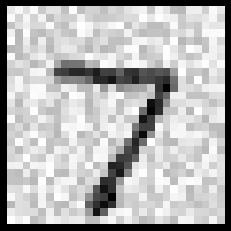

In [123]:
# noisy image
plt.imshow(X_test_mod.iloc[0].values.reshape(28,28), cmap= mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

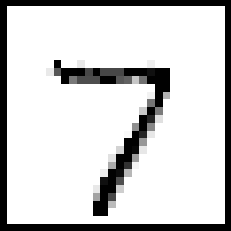

In [126]:
# clean image
plt.imshow(clean_digit.reshape(28,28), cmap= mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()